In [1]:
%matplotlib notebook 
# Import modules
import math
import numpy as np
import matplotlib.pyplot
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
import tables as tb
from pyne import data
import itertools
import re
import os


iso_list = ['Xe135', 'Te135','Kr83', 'I135','U235', 'U236', 'U238', 'Pu238','Pu239', 'Pu240', 'Pu241', 'Pu242', 'Am241', 'Am242', 'H3', 'He4']
colors = matplotlib.pyplot.rcParams['axes.prop_cycle'].by_key()['color']

def merge(a,b):
    final = np.zeros (len(a)+len(b))
    for i in range(len(a)):
        final[2*i]   = a[i]
        final[2*i+1] = b[i]
    return final

def elem_aaa(iso):
    m = re.match(r"(?P<letters>[a-zA-Z]+)(?P<the_rest>.+)$", iso)
    return [m.group('letters'), m.group('the_rest')]

def read_keff_h5(file):
    db = tb.open_file(file, mode='r')
    sim_param = db.root.simulation_parameters
    init_param = db.root.initial_depcode_siminfo
    # Keff at t=0 depletion step
    k_0 = np.array([x['keff_bds'][0] for x in sim_param.iterrows()])
    k_0_e = np.array([x['keff_bds'][1] for x in sim_param.iterrows()])
    # Keff at t=end depletion step
    k_1 = np.array([x['keff_eds'][0] for x in sim_param.iterrows()])
    k_1_e = np.array([x['keff_eds'][1] for x in sim_param.iterrows()])
    # Power level
    power = np.array([x['power_level'] for x in sim_param.iterrows()])
    day_eds = np.array([x['cumulative_time_at_eds'] for x in sim_param.iterrows()])
    day_bds = np.zeros_like(day_eds)
    for i in range(1, len(day_eds)):
        day_bds[i] = day_eds[i] - (day_eds[i] - day_eds[i-1])
    db.close()
    return np.around(day_bds*24.0,decimals=2), np.around(day_eds*24.0, decimals=2), k_0, k_1, k_0_e, k_1_e, power

def read_iso_m_h5(db_file, iso_list):
    db = tb.open_file(db_file, mode='r')
    fuel_bef_mat = db.root.materials.fuel.before_reproc.parameters
    fuel_bef = db.root.materials.fuel.before_reproc.comp
    isomap = fuel_bef.attrs.iso_map

    fuel_after_mat = db.root.materials.fuel.after_reproc.parameters
    fuel_after = db.root.materials.fuel.after_reproc.comp

    mass_b = np.array([x['mass'] for x in fuel_bef_mat.iterrows()])
    vol_b = np.array([x['volume'] for x in fuel_bef_mat.iterrows()])
    dens_b = np.array([x['density'] for x in fuel_bef_mat.iterrows()])

    mass_a = np.array([x['mass'] for x in fuel_after_mat.iterrows()])
    vol_a = np.array([x['volume'] for x in fuel_after_mat.iterrows()])
    dens_a = np.array([x['density'] for x in fuel_after_mat.iterrows()])

    mass_b = {}
    mass_a = {}
    for iso in iso_list:
        mass_b[iso] = 1e-6*np.array([row[isomap[iso]] for row in fuel_bef])
        mass_a[iso] = 1e-6*np.array([row1[isomap[iso]] for row1 in fuel_after])
    
    sim_param = db.root.simulation_parameters
    day_eds = np.array([x['cumulative_time_at_eds'] for x in sim_param.iterrows()])
    day_bds = np.zeros_like(day_eds)
    for i in range(1, len(day_eds)):
        day_bds[i] = day_eds[i] - (day_eds[i] - day_eds[i-1])
    db.close()
    return np.around(day_bds*24.0,decimals=2), np.around(day_eds*24.0, decimals=2),mass_b, mass_a  # mass in tonnes

/home/andrei2/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


In [25]:
t_indx_shutdown = 0
# Epsilon=91%, K_L=100ft/hr
file_list = ['../../msbr/load-following/large_eps/bol/msbr_lf_kl_100_bol.h5',
             '../../msbr/load-following/large_eps/mol/msbr_lf_kl_100_mol.h5',
             '../../msbr/load-following/large_eps/eol/msbr_lf_kl_100_eol_before_repro.h5'
            ]

# Epsilon=53%, K_L=25ft/hr
file_list = ['../../msbr/load-following/mid_eps/bol/msbr_lf_kl_25_bol.h5',
             '../../msbr/load-following/mid_eps/mol/msbr_lf_kl_25_mol.h5',
             '../../msbr/load-following/mid_eps/eol/msbr_lf_kl_25_eol.h5'
            ]

<IPython.core.display.Javascript object>


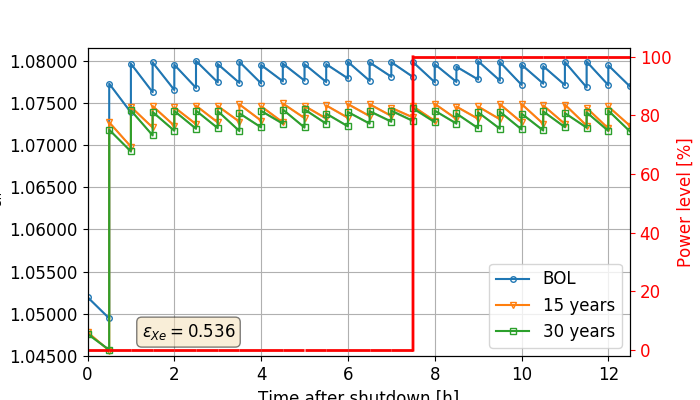

In [18]:
markers=itertools.cycle(('o','v','s','^','<','>','p','P','*','h','H','+','x','X','D','d','|','_'))
moment = itertools.cycle(('BOL', '15 years','30 years'))
# Initialize figure
fig_keff = matplotlib.pyplot.figure(1, figsize=(7,4))
ax1 = fig_keff.add_subplot(111)
ax1.grid(True)
for file in file_list:
    m=next(moment)
    mar=next(markers)
    db_file = os.path.join(os.getcwd(), file)
    t_bds, t_eds, k_bds, k_eds, k_bds_err, k_eds_err, power = read_keff_h5(db_file)    
    keff = merge(k_bds, k_eds)
    t = merge(t_bds, t_eds)
    err = merge(k_bds_err, k_eds_err)
    #ax1.plot(t_bds, k_bds, 'o-', label=r'$K_L$=8.4667 mm/s (BDS)', linewidth=0.9, alpha=0.8, markerfacecolor="None")
    #ax1.plot(t_eds, k_eds, 's-', label=m, linewidth=0.9, alpha=0.8, markerfacecolor="None")
    ax1.plot(t, keff, 'o-', label=m, linewidth=1.5, alpha=1, markerfacecolor="None", markersize=4, marker=mar)
    ax1.fill_between(t, keff-err, keff+err, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)
    #ax1.fill_between(t_eds, k_eds-k_eds_err, k_eds+k_eds_err, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)



ax1.legend(loc=4, fontsize=12)
ax1.set_ylabel(r'$k_{eff}$', fontsize=12)
ax1.set_xlabel('Time after shutdown [h]', fontsize=12)
ax1.set_ylim(1.045, 1.0815)
ax1.set_xlim(0,12.5)
ax1.tick_params('x', labelsize=12)
# ax1.set_xticks(days_tap)
ax1.tick_params('y', labelsize=12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = r'$\epsilon_{Xe}=0.536$'
ax1.text(0.1, 0.11, textstr,transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax2=ax1.twinx()
ax2.bar(t_bds, 0.0, bottom=100*power/np.amax(power),color='#f77777', alpha=1, align='edge', 
        width=t_bds[1]-t_bds[0], ls="-", edgecolor='#fc0303', linewidth=2, fill=False)
ax2.plot([7.5,7.5001],[0, 100], c='red', alpha=1, linewidth=2)
ax2.set_ylim(-2,103)
ax2.set_ylabel('Power level [%]', color='r', fontsize=12)
ax2.tick_params('y', colors='r', labelsize=12)


fig_keff.show()
#fig_keff.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch6/kl25_keff.png',bbox_inches='tight', dpi=700)

<IPython.core.display.Javascript object>


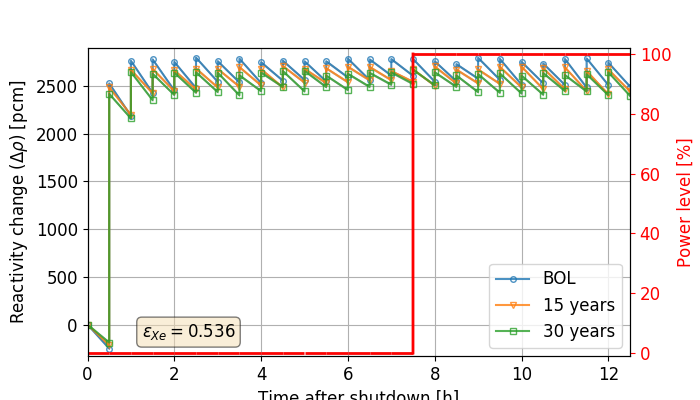

Maximum reactivity drop -189.006329 pcm
Maximum reactivity spike 2672.994137 pcm
[   0.         -189.00632858 2418.99490356 2161.99159622 2647.99594879
 2352.98871994 2629.99534607 2407.99188614 2641.99972153 2431.98871613
 2645.99323273 2438.99822235 2640.99836349 2403.99837494 2613.99745941
 2447.99852371 2642.98915863 2491.99867249 2658.99896622 2445.99580765
 2660.98976135 2490.99731445 2610.99338531 2459.99097824 2629.99534607
 2493.00003052 2639.99700546 2515.99550247 2644.99187469 2523.9944458
 2672.99413681 2509.99927521 2645.99323273 2493.00003052 2611.99474335
 2437.99686432 2625.98991394 2431.98871613 2633.98885727 2423.9897728
 2610.99338531 2410.99596024 2636.99293137 2449.98931885 2616.98961258
 2444.99444962 2625.98991394 2405.98917007 2645.99323273 2398.99158478]


In [19]:
markers=itertools.cycle(('o','v','s','^','<','>','p','P','*','h','H','+','x','X','D','d','|','_'))
moment = itertools.cycle(('BOL', '15 years','30 years'))
fig_rho = matplotlib.pyplot.figure(2, figsize=(7,4))
ax1 = fig_rho.add_subplot(111)
ax1.grid(True)
for file in file_list:
    m=next(moment)
    mar=next(markers)
    db_file = os.path.join(os.getcwd(), file)
    t_bds, t_eds, k_bds, k_eds, k_bds_err, k_eds_err, power = read_keff_h5(db_file)    
    keff = merge(k_bds, k_eds)
    t = merge(t_bds, t_eds)
    err = merge(k_bds_err, k_eds_err)
    ax1.plot(t, 1e+5*(keff-keff[t_indx_shutdown]), 'o-', label=m,
             marker=mar,linewidth=1.5, alpha=0.8, markerfacecolor="None", markersize=4)
    ax1.fill_between(t, 1e+5*(keff-keff[t_indx_shutdown]-err), 1e+5*(keff-keff[t_indx_shutdown]+err), edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)


ax1.legend(loc=0, fontsize=12)
ax1.set_ylabel(r'Reactivity change ($\Delta\rho$) [pcm]', fontsize=12)
ax1.set_xlabel('Time after shutdown [h]', fontsize=12)
ax1.set_xlim(0,12.5)
ax1.set_ylim(-330,2900)
ax1.tick_params('x', labelsize=12)
#ax1.set_xticks(t_eds)
ax1.tick_params('y', labelsize=12)
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#textstr = r'$\epsilon_{Xe}=0.915$'
textstr = r'$\epsilon_{Xe}=0.536$'
ax1.text(0.1, 0.11, textstr,transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax2=ax1.twinx()
ax2.bar(t_bds, 0.0, bottom=100*power/np.amax(power),color='#f77777', alpha=1, align='edge',
        width=t_bds[1]-t_bds[0], ls="-",edgecolor='#fc0303', linewidth=2, fill=False)
ax2.plot([7.5,7.5001],[0, 100], c='red', alpha=1, linewidth=2)
ax2.set_ylim(-1,102)
ax2.set_ylabel('Power level [%]', color='r', fontsize=12)
ax2.tick_params('y', colors='r', labelsize=12)


fig_rho.show()
#fig_rho.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch6/kl25_rho.png',bbox_inches='tight', dpi=700)
print('Maximum reactivity drop %f pcm' %(np.amin(1e+5*(keff-keff[0]))))
print('Maximum reactivity spike %f pcm' %(np.amax(1e+5*(keff-keff[t_indx_shutdown]))))
print(1e5*(keff-keff[0]))

<IPython.core.display.Javascript object>


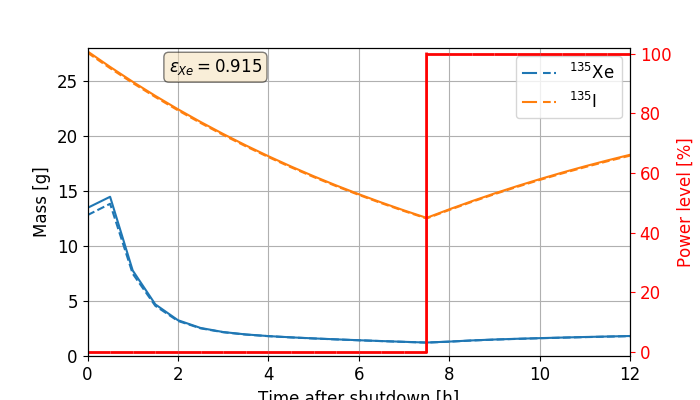

In [26]:
#plot_iso = ['He4']
#plot_iso = ['U235','U238']
plot_iso = ['Xe135', 'I135']
#print(len(t_comp[:3001]), len(t_comp_5))
moment = itertools.cycle(('BOL', '30 years'))
line_st = itertools.cycle(('-', '--'))

# Initialize figure
fig_comp = matplotlib.pyplot.figure(3, figsize=[7,4])
ax1 = fig_comp.subplots()
ax1.grid(True)

#for i in plot_iso:
    #ax1.set_prop_cycle(color=colors[1:])
#    el_aaa = elem_aaa(i)
#    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
#    for file in [file_list[0], file_list[-1]]:
#        lin=next(line_st)
#        mom=next(moment)
#        db_file = os.path.join(os.getcwd(), file)
#        t_bds, t_eds, mass_before, mass_after = read_iso_m_h5(db_file, [i])
#        t_comp = np.append(t_bds, t_eds[-1])
#        ax1.plot(t_comp, 1e6*mass_before[i], lin, label=str(k_name)+' ('+mom+')', linewidth=1.5, markerfacecolor='none')

t_bds, t_eds, mass_before, mass_after = read_iso_m_h5(os.path.join(os.getcwd(), file_list[-1]), plot_iso)
t_comp = np.append(t_bds, t_eds[-1])
x1, = ax1.plot(t_comp, 1e6*mass_before['Xe135'], '-', linewidth=1.5, markerfacecolor='none')
i1, = ax1.plot(t_comp, 1e6*mass_before['I135'], '-', linewidth=1.5, markerfacecolor='none')
t_bds, t_eds, mass_before, mass_after = read_iso_m_h5(os.path.join(os.getcwd(), file_list[0]), plot_iso)
ax1.set_prop_cycle(color=colors[0:])
x2, = ax1.plot(t_comp, 1e6*mass_before['Xe135'], '--', linewidth=1.5, markerfacecolor='none')
i2, = ax1.plot(t_comp, 1e6*mass_before['I135'], '--', linewidth=1.5, markerfacecolor='none')
    
l=ax1.legend([(x1,x2), (i1,i2)], [r'$^{135}$Xe', r'$^{135}$I'], scatterpoints=2,handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=12)
#ax1.legend(loc=2, bbox_to_anchor=(0.61, 0.44), fontsize=12)
#ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.tick_params('y', labelsize=12)
ax1.tick_params('x', labelsize=12)
ax1.set_ylabel('Mass [g]', fontsize=12)
ax1.set_xlabel('Time after shutdown [h]', fontsize=12)
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 28)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = r'$\epsilon_{Xe}=0.915$'
#textstr = r'$\epsilon_{Xe}=0.536$'
ax1.text(0.15, 0.97, textstr,transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax2=ax1.twinx()
ax2.bar(t_bds, 0.0, bottom=100*power/np.amax(power),color='#f77777', alpha=1, align='edge',
        width=t_bds[1]-t_bds[0], ls="-",edgecolor='#fc0303', linewidth=2, fill=False)
ax2.plot([7.5,7.5001],[0, 100], c='red', alpha=1, linewidth=2)
ax2.set_ylim(-1.5,102)
ax2.set_ylabel('Power level [%]', color='r', fontsize=12)
ax2.tick_params('y', colors='r', labelsize=12)

fig_comp.show()
#fig_comp.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch6/kl100_xe_i_ratio.png',bbox_inches='tight', dpi=700)

In [27]:
V = 4.43530000000000E+07 # cm3
NA = 6.02214076e23

db_file = os.path.join(os.getcwd(), file_list[-1])
t_bds, t_eds, mass_before, mass_after = read_iso_m_h5(db_file, iso_list)

N_xe_0 = mass_before['Xe135'][0]
N_i_0 = mass_before['I135'][0]
N_te_0 = mass_before['Te135'][0]


lamb_xe = data.decay_const('Xe-135')
lamb_i = data.decay_const('I-135')
lamb_te = data.decay_const('Te-135')
10
nom = lamb_xe*(lamb_i*(N_xe_0+N_i_0)-lamb_xe*N_xe_0)
den = lamb_i**2 * N_i_0
t_peak = np.log(nom/den) / (lamb_xe-lamb_i)

print("Operative excees reactivity %f pcm" %(1e5*(k_eds[0]-1.0)))
print('Analytical solution for the Xe-135 peak %f s, %f h' %(t_peak, t_peak/3600))
print('I135/Xe135 ratio at the beginning of the transient %f' 
        %(N_i_0/N_xe_0))
print('Xe135 concentration peak %f [%%]' %(100*np.amax(mass_before['Xe135']-N_xe_0)/N_xe_0))
print('Maximum reactivity change after shutdown %f pcm ' %(1e5*np.amin((k_eds-k_eds[t_indx_shutdown]))))

print(1e6*mass_before['Xe135'])

Operative excees reactivity 4572.999477 pcm
Analytical solution for the Xe-135 peak 24520.808904 s, 6.811336 h
I135/Xe135 ratio at the beginning of the transient 2.056977
Xe135 concentration peak 7.503240 [%]
Maximum reactivity change after shutdown 0.000000 pcm 
[13.46478497 14.47508007  7.77333665  4.69486888  3.25415321  2.55051717
  2.17963584  1.96042679  1.81176899  1.69725189  1.60046518  1.51394651
  1.43424236  1.35969171  1.28944215  1.22301632  1.30898436  1.41621918
  1.49864596  1.5653394   1.62351831  1.67669957  1.72627628  1.77299375
  1.81709548  1.85887375]
